# Water detection
Let's use EOReader for water detection

<div class="alert alert-warning">
  
<strong>Warning:</strong> You will need <strong>matplotlib</strong> to complete this tutorial
    
</div>

In [1]:
import os

# First of all, we need some satellite data. 
# Let's open a lightweight a Landsat-5 MSS collection 2 tile.
path = os.path.abspath("../../CI/DATA/LM05_L1TP_200029_19841014_20200902_02_T2.tar")

In [2]:
from eoreader.reader import Reader

# Create the reader
eoreader = Reader()

# This reader is a singleton can be called once and then open all your data.
# Use it like a logging.getLogger() instance

In [3]:
from eoreader.bands.alias import *

# Open your product
prod = eoreader.open(path) # No need to unarchive here

In [4]:
# Load those bands as a dict of xarray.DataArray
band_dict = prod.load(NDWI)
ndwi = band_dict[NDWI]

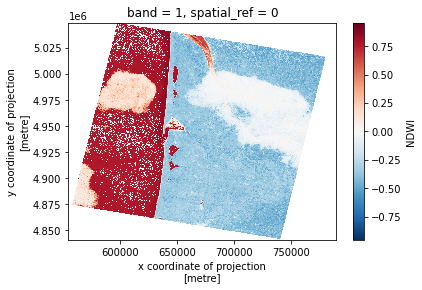

In [5]:
# The nan corresponds to the nodata you see on the footprint
%matplotlib inline

# Plot a subsampled version
ndwi.copy()[:, ::10, ::10].plot()

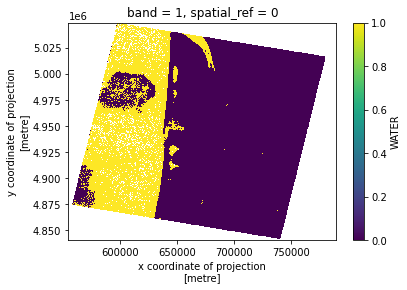

In [6]:
import xarray as xr
import numpy as np

# Assert water bodies when NDWI index > 0.2
water = xr.where(ndwi > 0.2, 1, 0)

# Set nodata where ndwi is nan.
# WARNING: the function xr.DataArray.where sets by default np.nan where the condition is false !
# See here: http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html
water = water.where(~np.isnan(ndwi))

# Plot a subsampled version
water = water.rename("WATER")
water[:, ::10, ::10].plot()